# Analyse des accidents sur voie publique en FRANCE

Les données correspondes aux accidents corporels sur la circulation publique de France en 2023. Les informations ont été recueillie par les unités de forces publiques qui ont intervenues.

Les données sont disponibles sous 4 fichiers :
- caractérstiques : informations sur les caractéristiques de l'accidents  
- lieux : informations sur le lieux de l'accidents
- véhicules : informations sur les véhicules impliqués
- usagers : informations sur les personnes impliqués

Chaque accidents est identifier par un numéro présent dans chaque fichier.

### Objecitf : comprendre les accidents pour pouvoir cibler les futures préventions routière, travaux etc...

- Classifier les accidents sous différentes catégories.
- Déterminer les variables explicatives les plus corrélés aux accidents mortels.
- Plan d'action pour certaines départements (dep = var expliqué)

### Fonction utile

In [1]:
def variables_uniques(df,exclude) :
    for col in df.columns:
        if col not in exclude:
            uniques = ', '.join(map(str, df[col].unique()))
            print(f"{col}: {uniques}")


### Importation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime

In [5]:
caract = pd.read_csv("acc_routes/caract-2023.csv", sep=";")
lieux = pd.read_csv("acc_routes/lieux-2023.csv",sep=";")
usagers = pd.read_csv("acc_routes/usagers-2023.csv",sep=";")
vehicules = pd.read_csv("acc_routes/vehicules-2023.csv",sep=";")

<ipython-input-5-8f52bffe4c9b>:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  lieux = pd.read_csv("acc_routes/lieux-2023.csv",sep=";")


On vérifie la taille des ensembles

In [6]:
print(caract.shape)
print(lieux.shape)
print(usagers.shape)
print(vehicules.shape)

(54822, 15)
(70860, 18)
(125789, 16)
(93585, 11)


-> On remarque que les ensembles ont des tailles différentes. On explique cela par la dublication d'enregistrements si l'accident concerne plusieurs lieux,véhicules et personnes.

----

## Pré-traitement

On va s'intérresser à chaque variables qui peuvent être utiles dans notre analyse.


### Dataset CARACTERISTIQUE :
Nous jugeons certaines variables pas intéressantes pour l'étude. Nous allons les supprimer.

On souhaite garder : jour, mois, an, hrmn, lum, agg, int, atm, col, dep

In [7]:
caract = caract.drop(columns=["adr",'com'])

#### Valeurs dupliqués

In [8]:
caract.duplicated().value_counts()

False    54822
Name: count, dtype: int64

Il y en a aucune valeurs en doubles

#### Types des données

In [9]:
caract.dtypes

Num_Acc     int64
jour        int64
mois        int64
an          int64
hrmn       object
lum         int64
dep        object
agg         int64
int         int64
atm         int64
col         int64
lat        object
long       object
dtype: object

Il y a deux types object : hrmn et dep

#### Catégorisation

- On va convertir la variable (horraire) hrmn en trois catégorie : matin / après-midi / soir (pour limiter l'explosition du nombre de dimensions lors du one-hot)

In [10]:
caract["hrmn"]

0        06:00
1        05:30
2        20:50
3        23:57
4        00:50
         ...  
54817    20:45
54818    19:10
54819    09:40
54820    17:20
54821    16:30
Name: hrmn, Length: 54822, dtype: object

In [11]:
caract["hrmn"] = caract["hrmn"].apply(lambda x : int(x[:2]))

In [12]:
caract.rename(columns={"hrmn":'heure_categorie'},inplace=True)

In [13]:
def categoriser_heure(h):
    if 6 <= h < 12:
        return 'matin'
    elif 12 <= h < 18:
        return 'après-midi'
    elif 18 <= h < 24:
        return 'soir'
    else:
        return 'nuit'


In [14]:
caract['heure_categorie'] = caract['heure_categorie'].apply(categoriser_heure)

- On va également catégoriser les jours en semaine/weekend. Cette encapsulation est plus intéreprétable, plus informative.

In [15]:
caract['jour'].unique()

array([ 7,  6,  8,  3,  5,  4, 24, 18, 28, 23, 27, 17,  1, 30, 15,  2, 26,
       29, 19, 10, 25, 22, 31, 11, 21, 13, 20, 16, 12, 14,  9])

In [16]:
def categoriser_jour(j,mois):
    date = datetime.date(2023, mois, j)
    if date.weekday() < 5:
        return 'semaine'
    else:
        return 'weekend'

In [17]:
caract['jour_categorie'] = caract.apply(lambda row: categoriser_jour(row['jour'], row['mois']), axis=1)
caract.drop(columns=["jour"],inplace=True)

- On va catégoriser les mois

In [18]:
def categoriser_mois(m):
    if m in [12,1,2]:
        return 'hiver'
    elif 3 <= m <= 6:
        return 'printemps'
    elif 7 <= m <= 9:
        return 'été'
    else:
        return 'automne'


In [19]:
caract['mois_categorie'] = caract['mois'].apply(categoriser_mois)

- On va catégoriser les départements

In [20]:
def categoriser_dep(dep):
    # Paris
    if dep == "75":
        return "Paris"

    # Grandes Villes (régions métropolitaines très peuplées)
    elif dep in ["69", "31", "13", "33", "59", "92", "93", "94"]:
        return "Grandes Villes"

    # Île-de-France hors Paris
    elif dep in ["77", "78", "91", "95"]:
        return "Île-de-France"

    # Sud (PACA, Occitanie, Corse élargie)
    elif dep in ["06", "13", "30", "34", "66", "83", "84", "2A", "2B", "04", "05", "07", "09", "11", "12", "81", "82"]:
        return "Sud"

    # Nord
    elif dep in ["59", "62", "80", "02", "60", "08"]:
        return "Nord"

    # Est (Grand Est élargi + Bourgogne/Franche-Comté)
    elif dep in ["67", "68", "88", "54", "55", "57", "52", "10", "70", "90", "25", "39", "21", "71", "89", "58"]:
        return "Est"

    # Ouest (Bretagne + Pays de la Loire élargi)
    elif dep in ["29", "22", "35", "56", "44", "49", "53", "72", "85", "50", "61", "14"]:
        return "Ouest"

    # Centre (Centre-Val de Loire + Massif central)
    elif dep in ["45", "28", "41", "18", "36", "37", "03", "23", "19", "15", "43", "63", "87"]:
        return "Centre"

    # Sud-Ouest (Nouvelle-Aquitaine hors métropoles)
    elif dep in ["16", "17", "24", "40", "47", "64", "79", "86", "87"]:
        return "Sud-Ouest"

    # DROM
    elif dep in ["971", "972", "973", "974", "976"]:
        return "Outre-Mer"

    # Par défaut
    else:
        return "Autre"


In [21]:
caract["dep_cat"] = caract["dep"].apply(categoriser_dep)

Vérification

In [22]:
caract.dtypes

Num_Acc             int64
mois                int64
an                  int64
heure_categorie    object
lum                 int64
dep                object
agg                 int64
int                 int64
atm                 int64
col                 int64
lat                object
long               object
jour_categorie     object
mois_categorie     object
dep_cat            object
dtype: object

#### Valeurs manquantes

- Valeurs NaN

In [23]:
print(caract.isna().sum())

Num_Acc            0
mois               0
an                 0
heure_categorie    0
lum                0
dep                0
agg                0
int                0
atm                0
col                0
lat                0
long               0
jour_categorie     0
mois_categorie     0
dep_cat            0
dtype: int64


- Autres valeurs manquantes, indiqué par -1 (non renseigné)

In [24]:
print((caract["col"]== -1).sum())
print((caract["atm"]== -1).sum())

13
4


In [25]:
def remplacer_mediane(df,cols):
    for col in cols:
        m_value = df[col].median()
        df[col] = df[col].fillna(int(m_value))
        df[col] = df[col].replace({-1:int(m_value)})
    return df

#### Valeurs abhérantes

In [26]:
caract.describe()

Num_Acc          mois       an           lum           agg  \
count  5.482200e+04  54822.000000  54822.0  54822.000000  54822.000000   
mean   2.023000e+11      6.744628   2023.0      1.937653      1.626135   
std    1.582589e+04      3.368853      0.0      1.485124      0.483833   
min    2.023000e+11      1.000000   2023.0     -1.000000      1.000000   
25%    2.023000e+11      4.000000   2023.0      1.000000      1.000000   
50%    2.023000e+11      7.000000   2023.0      1.000000      2.000000   
75%    2.023000e+11     10.000000   2023.0      3.000000      2.000000   
max    2.023001e+11     12.000000   2023.0      5.000000      2.000000   

                int           atm           col  
count  54822.000000  54822.000000  54822.000000  
mean       2.085167      1.636296      4.034129  
std        2.022823      1.692539      1.973341  
min       -1.000000     -1.000000     -1.000000  
25%        1.000000      1.000000      3.000000  
50%        1.000000      1.000000      3.000000  
75%        2.000000      1.000000      6.000000  
max        9.000000      9.000000      7.000000

- Pas de valeurs abhérantes du point de vue de l'écart type, pour les variables numérique

In [27]:
variables_uniques(caract,["Num_Acc"])

mois: 5, 4, 3, 12, 11, 7, 8, 2, 1, 6, 10, 9
an: 2023
heure_categorie: matin, nuit, soir, après-midi
lum: 1, 5, 3, 2, 4, -1
dep: 75, 94, 95, 93, 92, 01, 38, 91, 22, 972, 974, 06, 67, 56, 2B, 82, 11, 63, 47, 39, 29, 26, 60, 45, 64, 16, 07, 17, 23, 87, 30, 34, 62, 987, 971, 66, 83, 69, 33, 80, 13, 973, 78, 976, 2A, 76, 74, 71, 72, 61, 86, 70, 65, 44, 54, 53, 59, 85, 57, 28, 37, 52, 51, 49, 88, 10, 36, 35, 31, 27, 84, 21, 08, 02, 81, 77, 14, 50, 42, 09, 15, 73, 32, 04, 58, 978, 68, 988, 55, 41, 43, 25, 05, 12, 19, 79, 40, 18, 03, 46, 90, 24, 89, 48, 986, 977, 975
agg: 2, 1
int: 4, 1, 3, 2, 9, 6, 8, 5, 7, -1
atm: 2, 3, 8, 1, 5, 7, 9, 6, 4, -1
col: 7, 6, 1, 5, 3, 4, 2, -1
lat: 48,86638600, 48,84547782, 48,76240000, 48,73248432, 48,78581000, 48,83717000, 48,78693219, 48,78238000, 48,76240184, 48,83266000, 48,99572240, 48,83611000, 48,95859534, 48,94211000, 48,90631671, 48,88677185, 48,80202300, 46,08672900, 45,43994100, 48,33290200, 48,63356800, 14,45471200,  -21,28161700, 43,64474400, 48,799

- Pas de valeurs erronées pour les valeurs catégorique

### Dataset LIEUX :

On souhaite garder : catr, circ, nbv, prof, plan, lartpc, larrrout, surf, infra, situ ,vma

In [28]:
lieux = lieux.drop(columns=["voie",'v1','v2','vosp','pr','pr1'])

#### Valeurs dupliqués

In [29]:
bool_series = lieux.duplicated()
print(bool_series.value_counts())

False    68176
True      2684
Name: count, dtype: int64


Exemple :

In [30]:
lieux.loc[3]

Num_Acc    202300000003
catr                  3
circ                  2
nbv                   4
prof                  1
plan                  1
lartpc              NaN
larrout              -1
surf                  2
infra                 5
situ                  1
vma                  50
Name: 3, dtype: object

In [31]:
lieux.loc[4]

Num_Acc    202300000003
catr                  3
circ                  2
nbv                   4
prof                  1
plan                  1
lartpc              NaN
larrout              -1
surf                  2
infra                 5
situ                  1
vma                  50
Name: 4, dtype: object

Il y en a 2684, on va les supprimer

In [32]:
lieux = lieux[-bool_series]

#### Types

In [33]:
lieux.dtypes

Num_Acc     int64
catr        int64
circ        int64
nbv        object
prof        int64
plan        int64
lartpc     object
larrout    object
surf        int64
infra       int64
situ        int64
vma         int64
dtype: object

Il y a trois types en object : nbv, lartpc, larrout

On peut les numériser (plus simple pour ensuite utiliser des métriques de distances). Seulement certaines valeurs sont en text :

In [34]:
valeurs_problemes = lieux.loc[~lieux["nbv"].str.isnumeric(), "nbv"].unique()
valeurs_problemes

array([' -1', '#VALEURMULTI'], dtype=object)

In [35]:
lieux["nbv"].value_counts()

nbv
2               40595
1                7987
4                5989
3                5016
 -1              4138
0                2021
6                1189
5                 716
8                 289
7                  91
#VALEURMULTI       54
10                 47
9                  22
12                 15
11                  7
Name: count, dtype: int64

Transformation numérique

In [36]:
lieux[["lartpc", "larrout", "nbv"]] = lieux[["lartpc", "larrout", "nbv"]].apply(lambda x: x.str.replace(',', '.'))
lieux[["lartpc", "larrout", "nbv"]] = lieux[["lartpc", "larrout", "nbv"]].apply(pd.to_numeric, errors='coerce')


Les valeurs : #VALEURMULTI deviennent NAN, on va les remplacer par -1

In [37]:
lieux["nbv"].fillna(-1, inplace=True)

<ipython-input-37-87aacc79d22d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lieux["nbv"].fillna(-1, inplace=True)


#### Valeurs manquantes

In [38]:
print(lieux.isna().sum())

Num_Acc        0
catr           0
circ           0
nbv            0
prof           0
plan           0
lartpc     68147
larrout        0
surf           0
infra          0
situ           0
vma            0
dtype: int64


Autres valeurs manquantes, indiqué par -1 (non renseigné)

In [39]:
print((lieux["prof"]== -1).sum())
print((lieux["surf"]== -1).sum())
print((lieux["infra"]== -1).sum())
print((lieux["situ"]== -1).sum())
print((lieux["circ"]== -1).sum())
print((lieux["plan"]== -1).sum())

211
208
900
198
4930
164


La majorité des variable ont très peu de valeurs manquantes.

On va supprimer la colonnes lartpc car elles possèdent trop de valeurs manquantes

In [40]:
lieux = lieux.drop(columns=["lartpc"])

#### Valeurs abhérantes

In [41]:
lieux.describe()

Num_Acc          catr          circ           nbv          prof  \
count  6.817600e+04  68176.000000  68176.000000  68176.000000  68176.000000   
mean   2.023000e+11      3.385062      1.711189      2.032636      1.211834   
std    1.581821e+04      1.124865      0.951353      1.364855      0.541558   
min    2.023000e+11      1.000000     -1.000000     -1.000000     -1.000000   
25%    2.023000e+11      3.000000      1.000000      2.000000      1.000000   
50%    2.023000e+11      3.000000      2.000000      2.000000      1.000000   
75%    2.023000e+11      4.000000      2.000000      2.000000      1.000000   
max    2.023001e+11      9.000000      4.000000     12.000000      4.000000   

               plan       larrout          surf         infra          situ  \
count  68176.000000  68176.000000  68176.000000  68176.000000  68176.000000   
mean       1.275522      1.030951      1.255236      0.815214      1.628139   
std        0.663740      3.819110      0.765248      2.172590      1.646833   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        1.000000     -1.000000      1.000000      0.000000      1.000000   
50%        1.000000     -1.000000      1.000000      0.000000      1.000000   
75%        1.000000      3.000000      1.000000      0.000000      1.000000   
max        4.000000     47.000000      9.000000      9.000000      8.000000   

                vma  
count  68176.000000  
mean      53.514257  
std       26.334853  
min       -1.000000  
25%       30.000000  
50%       50.000000  
75%       70.000000  
max      130.000000

- Pas de valeurs abhérantes du point de vue de l'écart type pour les variables numériques

In [42]:
variables_uniques(lieux,["Num_Acc","larrout","nbv","vma"])

catr: 4, 3, 2, 1, 9, 6, 7, 5
circ: 1, 2, 3, 4, -1
prof: 1, 2, 3, 4, -1
plan: 1, 2, 4, 3, -1
surf: 2, 1, -1, 3, 6, 9, 7, 5, 8, 4
infra: 0, 5, 3, 9, 1, 2, -1, 8, 6, 4, 7
situ: 1, 8, 4, 3, 5, 2, -1, 6


- Pas de valeurs erronées pour les valeurs catégorique

### Dataset VÉHICULES :

On veut garder les variables : catv, obs, obsm, choc, manv, motor, occutc, id_vehicule

In [43]:
vehicules = vehicules.drop(columns=["senc","num_veh"])

#### Valeurs dupliquées

In [44]:
vehicules.duplicated().value_counts()

False    93585
Name: count, dtype: int64

#### Types

In [45]:
vehicules.dtypes

Num_Acc          int64
id_vehicule     object
catv             int64
obs              int64
obsm             int64
choc             int64
manv             int64
motor            int64
occutc         float64
dtype: object

On va regrouper la variable MOTOR (pour limiter l'explosion lors de l'encodage binaire en one hot ):

In [46]:
def sous_categoriser_catv(catv):
    if catv in [1, 30, 31, 32, 33, 34, 35, 36, 41, 42, 43]:
        return '2 roues'
    elif catv in [7, 10]:
        return 'Véhicules légers'
    elif catv in [13, 14, 15, 16, 17]:
        return 'Poids lourds'
    elif catv in [37, 38]:
        return 'Transports en commun'
    elif catv in [20, 21]:
        return 'Véhicules spéciaux'
    elif catv in [50, 60, 80]:
        return 'Engins de déplacement personnel'
    elif catv in [39, 40]:
        return 'Rails (Train/Tramway)'
    elif catv in [0, 99]:
        return 'Autre/Indéterminé'
    else:
        return 'Inconnu'

# Appliquer la fonction de sous-catégorisation
vehicules['catv_categorie'] = vehicules['catv'].apply(sous_categoriser_catv)
vehicules = vehicules.drop(columns=["catv"])

##### Première observation

-> Les véhicules avec le plus d'accidents sont les motos et les véhicules légers.

In [47]:
cat_vehicule = vehicules.groupby("catv_categorie").size().reset_index(name="number")
cat_vehicule

catv_categorie  number
0                          2 roues   20366
1                Autre/Indéterminé     652
2  Engins de déplacement personnel    3407
3                          Inconnu    3791
4                     Poids lourds    2614
5            Rails (Train/Tramway)     149
6             Transports en commun     838
7                 Véhicules légers   61473
8               Véhicules spéciaux     295

In [48]:
cat_vehicule["catv_categorie"] =cat_vehicule["catv_categorie"].apply(lambda x : x[:10])

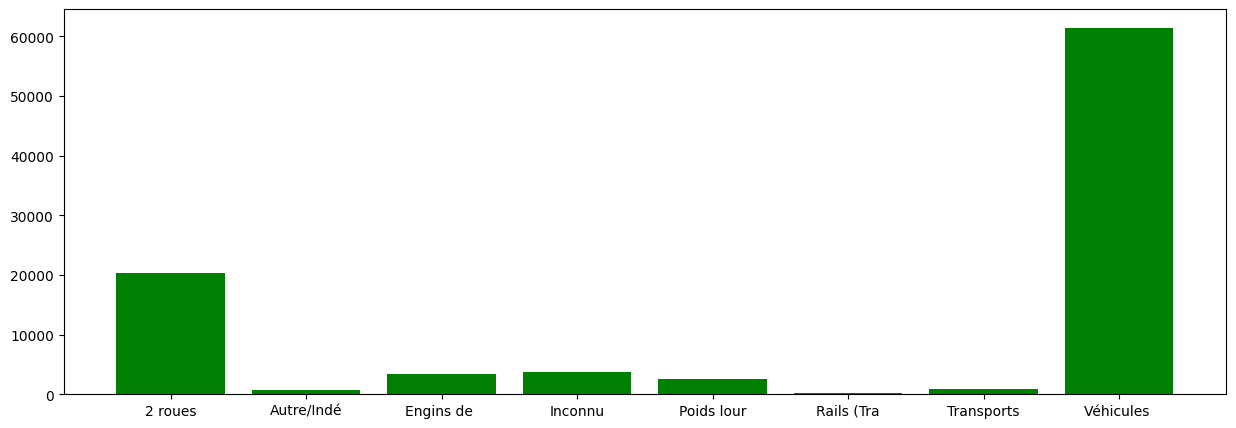

In [49]:
plt.figure(figsize=(15,5))
plt.bar(cat_vehicule["catv_categorie"],cat_vehicule["number"],color="green")
plt.show()

#### Valeurs manquantes

In [50]:
vehicules.isna().sum()

Num_Acc               0
id_vehicule           0
obs                   0
obsm                  0
choc                  0
manv                  0
motor                 0
occutc            92747
catv_categorie        0
dtype: int64

Autres

In [51]:
print((vehicules["obs"] == -1).sum())
print((vehicules["obsm"] == -1).sum())
print((vehicules["choc"] == -1).sum())
print((vehicules["manv"] == -1).sum())
print((vehicules["motor"] == -1).sum())


57
46
58
37
181


On supprime la colonne occutc qui possède trop de valeurs manquantes.

In [52]:
vehicules = vehicules.drop(columns=["occutc"])

#### Valeurs abhérantes

In [53]:
vehicules.describe()

Num_Acc           obs          obsm          choc          manv  \
count  9.358500e+04  93585.000000  93585.000000  93585.000000  93585.000000   
mean   2.023000e+11      1.050307      1.655297      2.877117      6.772122   
std    1.581615e+04      3.168680      1.258317      2.413490      7.792551   
min    2.023000e+11     -1.000000     -1.000000     -1.000000     -1.000000   
25%    2.023000e+11      0.000000      1.000000      1.000000      1.000000   
50%    2.023000e+11      0.000000      2.000000      2.000000      2.000000   
75%    2.023000e+11      0.000000      2.000000      4.000000     14.000000   
max    2.023001e+11     17.000000      9.000000      9.000000     26.000000   

              motor  
count  93585.000000  
mean       1.304515  
std        1.141443  
min       -1.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        6.000000

- Pas de valeurs abhérantes du point de vue de l'écart type pour les variables numériques

In [54]:
variables_uniques(vehicules,["Num_Acc","id_vehicule"])

obs: 0, 4, 7, 12, 1, 5, 13, 2, 6, 3, 14, 8, 16, 10, 15, 9, -1, 11, 17
obsm: 0, 1, 2, 9, 4, 5, -1, 6
choc: 5, 1, 2, 9, 4, 3, 0, 8, 7, 6, -1
manv: 1, 16, 15, 2, 0, 23, 26, 4, 11, 13, 17, 9, 6, 21, 20, 12, 19, 14, 3, 5, 7, 18, 22, 10, 25, 24, -1, 8
motor: 1, 4, 0, 2, 3, 5, -1, 6
catv_categorie: 2 roues, Véhicules légers, Inconnu, Engins de déplacement personnel, Poids lourds, Transports en commun, Autre/Indéterminé, Rails (Train/Tramway), Véhicules spéciaux


- Pas de valeurs erronées pour les valeurs catégorique

### Dataset USAGERS :

On souhaite garder les variables : id_usagers, id_vehicule, place, catu, grav, sexe, an_nais, trajet, secu1, secu2, secu3, locp, actp, etatp

In [55]:
usagers = usagers.drop(columns=["num_veh"])

#### Types

In [56]:
usagers.dtypes

Num_Acc          int64
id_usager       object
id_vehicule     object
place            int64
catu             int64
grav             int64
sexe             int64
an_nais        float64
trajet           int64
secu1            int64
secu2            int64
secu3            int64
locp             int64
actp            object
etatp            int64
dtype: object

La variable actp est object.

#### Valeurs manquantes

In [57]:
usagers.isna().sum()

Num_Acc           0
id_usager         0
id_vehicule       0
place             0
catu              0
grav              0
sexe              0
an_nais        2598
trajet            0
secu1             0
secu2             0
secu3             0
locp              0
actp              0
etatp             0
dtype: int64

In [58]:
usagers.size

1886835

In [59]:
print((usagers["trajet"] == -1).sum()) # Non renseigné
print((usagers["trajet"] == 0).sum())  # Non renseigné
print((usagers["secu1"] == -1).sum())
print((usagers["secu2"] == -1).sum())
print((usagers["secu3"] == -1).sum())
print((usagers["actp"] == "B").sum())  # Inconue
print((usagers["locp"] == -1).sum())
print((usagers["etatp"] == -1).sum())
print((usagers["grav"] == -1).sum())

2499
33303
2292
55419
123392
374
63330
115690
118


On supprime les colonnes avec beaucoup de variables manquantes

In [60]:
usagers = usagers.drop(columns=["trajet","secu2","secu3","secu2","etatp"])

#### Valeurs abhérantes

In [61]:
usagers.describe()

Num_Acc          place           catu           grav  \
count  1.257890e+05  125789.000000  125789.000000  125789.000000   
mean   2.023000e+11       2.091646       1.332684       2.514544   
std    1.582901e+04       2.582452       0.611056       1.377953   
min    2.023000e+11      -1.000000       1.000000      -1.000000   
25%    2.023000e+11       1.000000       1.000000       1.000000   
50%    2.023000e+11       1.000000       1.000000       3.000000   
75%    2.023000e+11       2.000000       2.000000       4.000000   
max    2.023001e+11      10.000000       3.000000       4.000000   

                sexe        an_nais          secu1           locp  
count  125789.000000  123191.000000  125789.000000  125789.000000  
mean        1.274134    1984.252023       1.932323      -0.236046  
std         0.561198      19.099389       2.371647       1.279765  
min        -1.000000    1913.000000      -1.000000      -1.000000  
25%         1.000000    1971.000000       1.000000      -1.000000  
50%         1.000000    1988.000000       1.000000      -1.000000  
75%         2.000000    2000.000000       2.000000       0.000000  
max         2.000000    2023.000000       9.000000       9.000000

- Pas de valeurs abhérantes au niveau de l'écart-type / min / max (années de naissance 1913 soit 100 ans haha)

In [62]:
variables_uniques(usagers,["Num_Acc","id_usager","id_vehicule","an_nais"])

place: 1, 10, 2, 4, 3, 7, 9, 6, 5, 8, -1
catu: 1, 3, 2
grav: 4, 1, 3, 2, -1
sexe: 1, 2, -1
secu1: 2, 1, 0, 8, 3, 9, -1, 4, 6, 5, 7
locp: -1, 2, 0, 3, 1, 8, 5, 4, 6, 9, 7
actp:  -1, 3, 0, 1, 5, 9, B, 2, 4, A, 7, 6, 8


- Pas de valeurs erronées pour les valeurs catégorique

## Vue globale


##### Evolution du nombre d'accidents dans l'années

In [63]:
acc_per_month = caract.groupby('mois').size().reset_index(name='accidents')
acc_per_month

mois  accidents
0      1       4053
1      2       3682
2      3       3998
3      4       4162
4      5       4767
5      6       5452
6      7       4754
7      8       4121
8      9       5161
9     10       5389
10    11       4833
11    12       4450

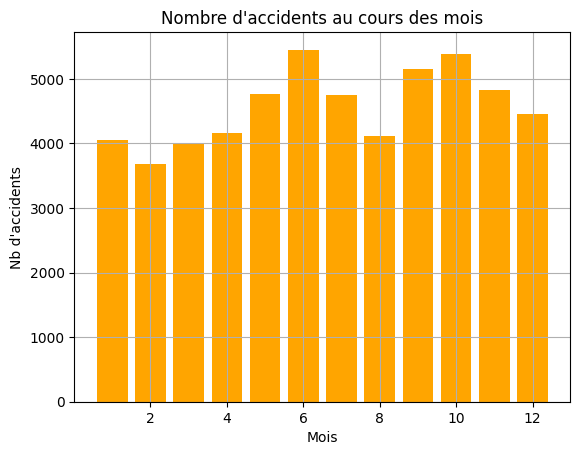

In [64]:
plt.bar(acc_per_month["mois"],acc_per_month["accidents"],color="orange")
plt.title("Nombre d'accidents au cours des mois")
plt.xlabel("Mois")
plt.ylabel("Nb d'accidents")
plt.grid()
plt.show()

- Observation : on remarque deux pics, le mois de juin et d'octobre. Deplus la période avec le moins d'accidents correspond à l'hiver.

##### Evolution de la proportion de la gravité

In [65]:
caract_usager = caract.merge(usagers,on="Num_Acc")
caract_usager

Num_Acc  mois    an heure_categorie  lum  dep  agg  int  atm  \
0       202300000001     5  2023           matin    1   75    2    4    2   
1       202300000002     5  2023            nuit    5   94    2    1    3   
2       202300000002     5  2023            nuit    5   94    2    1    3   
3       202300000003     5  2023            soir    1   94    2    3    2   
4       202300000003     5  2023            soir    1   94    2    3    2   
...              ...   ...   ...             ...  ...  ...  ...  ...  ...   
125784  202300054821    10  2023      après-midi    1  973    1    6    1   
125785  202300054821    10  2023      après-midi    1  973    1    6    1   
125786  202300054822    10  2023      après-midi    1   69    2    1    6   
125787  202300054822    10  2023      après-midi    1   69    2    1    6   
125788  202300054822    10  2023      après-midi    1   69    2    1    6   

        col  ...    id_usager  id_vehicule place catu grav sexe an_nais  \
0         7  ...  203 851 184  155 680 557     1    1    4    1  1978.0   
1         6  ...  203 851 182  155 680 556     1    1    1    2  1997.0   
2         6  ...  203 851 183  155 680 556    10    3    3    1  1997.0   
3         1  ...  203 851 180  155 680 554     1    1    3    1  1987.0   
4         1  ...  203 851 181  155 680 555     1    1    1    2  1984.0   
...     ...  ...          ...          ...   ...  ...  ...  ...     ...   
125784    3  ...  203 720 720  155 583 346     1    1    4    1  1971.0   
125785    3  ...  203 720 721  155 583 347     1    1    1    2  1968.0   
125786    3  ...  203 720 717  155 583 344     2    2    1    2  2003.0   
125787    3  ...  203 720 718  155 583 344     1    1    1    2  2002.0   
125788    3  ...  203 720 719  155 583 345     1    1    3    2  1995.0   

        secu1  locp  actp  
0           2    -1    -1  
1           1    -1    -1  
2           0     2     3  
3           2     0     0  
4           1     0     0  
...       ...   ...   ...  
125784      2     0     0  
125785      1     0     0  
125786      1    -1    -1  
125787      1    -1    -1  
125788      2    -1    -1  

[125789 rows x 25 columns]

In [66]:
grav_counts = caract_usager.groupby(["mois","grav"]).size().unstack()
grav_counts

grav  -1     1    2     3     4
mois                           
1      7  3847  255  1315  3754
2      7  3605  231  1257  3305
3      7  3881  217  1248  3719
4      6  4182  250  1464  3955
5      8  4638  261  1724  4323
6     10  5148  306  1979  4862
7     11  4662  323  1950  4191
8      6  3992  303  1757  3560
9     12  4942  311  1872  4545
10    11  5254  327  1828  4816
11    17  4762  303  1463  4489
12    16  4486  311  1414  4084

In [67]:
proportions = grav_counts.div(grav_counts.sum(axis=1), axis=0)
proportions

grav        -1         1         2         3         4
mois                                                  
1     0.000763  0.419154  0.027784  0.143277  0.409022
2     0.000833  0.428911  0.027484  0.149554  0.393218
3     0.000772  0.427800  0.023920  0.137566  0.409943
4     0.000609  0.424267  0.025363  0.148524  0.401238
5     0.000730  0.423407  0.023827  0.157385  0.394650
6     0.000813  0.418367  0.024868  0.160829  0.395124
7     0.000988  0.418605  0.029002  0.175092  0.376313
8     0.000624  0.415055  0.031503  0.182678  0.370139
9     0.001027  0.423044  0.026622  0.160247  0.389060
10    0.000899  0.429389  0.026724  0.149395  0.393593
11    0.001541  0.431575  0.027461  0.132590  0.406833
12    0.001552  0.435069  0.030162  0.137135  0.396082

<Axes: xlabel='mois'>

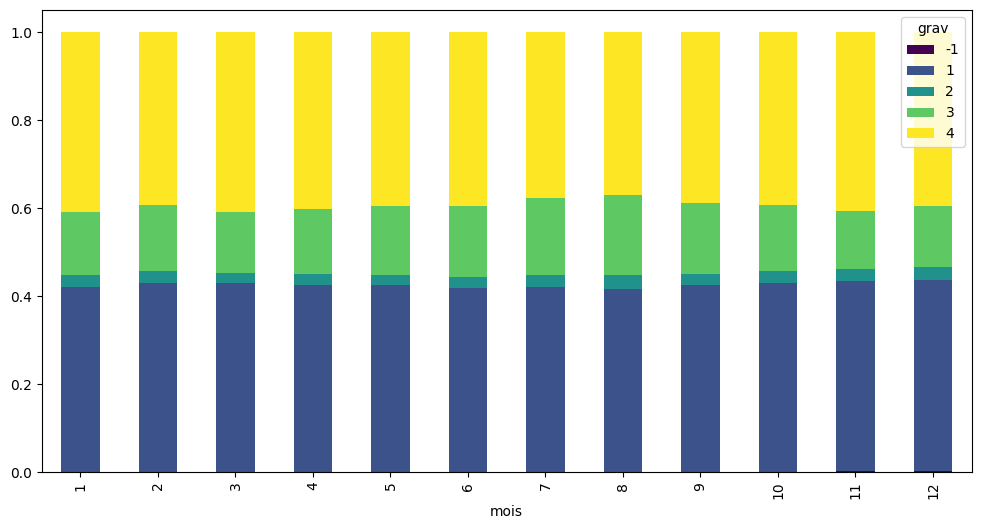

In [68]:
proportions.plot(kind="bar",stacked=True,figsize=(12,6),colormap="viridis")

- Observation : les taux de gravités n'évoluent selon les mois

##### Répartition du nombre d'accidents dans le TOP 10 des départements

In [69]:
acc_per_dep = caract.groupby("dep").size().reset_index(name="accidents").sort_values(by="accidents",ascending=False)
acc_per_dep_top_10 = acc_per_dep.iloc[:10]
autres_dep = pd.DataFrame({
    "dep":["Autres"],
    "accidents": [acc_per_dep.iloc[10:]["accidents"].sum()]
})
acc_per_dep_final = pd.concat([acc_per_dep_top_10,autres_dep], ignore_index=True)
acc_per_dep_final

dep  accidents
0       75       4763
1       93       2650
2       92       2563
3       94       2204
4       13       2057
5       69       1921
6       91       1319
7       33       1189
8       59       1004
9       95        906
10  Autres      34246

##### TODO : normaliser par le nombre d'habitant

20


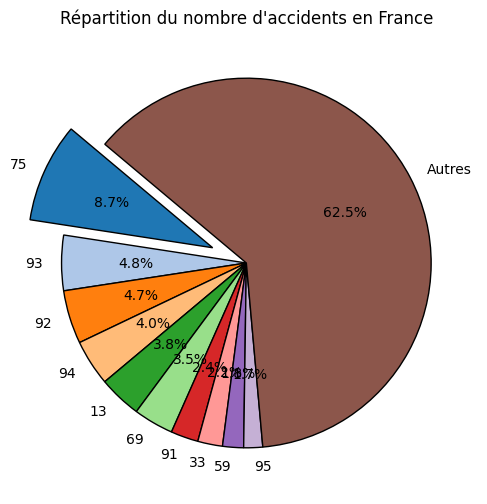

In [ ]:

colors = plt.cm.tab20.colors
print(len(colors))

# Séparer un département (exemple : le premier)
explode = [0.2 if i == 0 else 0 for i in range(len(acc_per_dep_final))]  # Mettre un écart pour le premier élément

plt.figure(figsize=(6, 6))
plt.pie(acc_per_dep_final["accidents"],
        labels=acc_per_dep_final["dep"],
        autopct='%1.1f%%',  # %
        startangle=140,
        colors=colors[:len(acc_per_dep_final)],
        explode=explode,
        wedgeprops={'edgecolor': 'black'})

plt.title('Répartition du nombre d\'accidents en France')
plt.show()


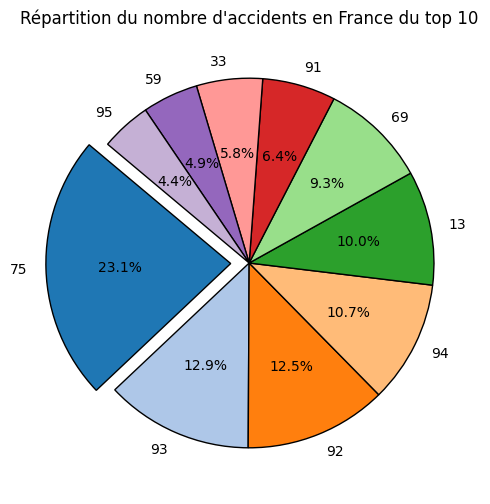

In [ ]:
explode = [0.1 if i == 0 else 0 for i in range(len(acc_per_dep_top_10))]  # Mettre un écart pour le premier élément

plt.figure(figsize=(6, 6))
plt.pie(acc_per_dep_top_10["accidents"],
        labels=acc_per_dep_top_10["dep"],
        autopct='%1.1f%%',  # %
        startangle=140,
        colors=colors[:len(acc_per_dep_top_10)],
        explode=explode,
        wedgeprops={'edgecolor': 'black'})

plt.title('Répartition du nombre d\'accidents en France du top 10')
plt.show()

- Observation : Paris est le département qui comptabilise le plus d'accidents

#### De même selon les départements en catégorie

In [ ]:
acc_per_dep = caract.groupby("dep_cat").size().reset_index(name="accidents").sort_values(by="accidents",ascending=False)
acc_per_dep_top_10 = acc_per_dep.iloc[:10]
autres_dep = pd.DataFrame({
    "accidents": [acc_per_dep.iloc[10:]["accidents"].sum()]
})
acc_per_dep_final = pd.concat([acc_per_dep_top_10,autres_dep], ignore_index=True)
acc_per_dep_final

dep_cat  accidents
0   Grandes Villes      14123
1            Ouest       6008
2              Sud       5775
3            Autre       5299
4            Paris       4763
5              Est       4521
6    Île-de-France       3763
7           Centre       3624
8        Outre-Mer       2740
9        Sud-Ouest       2442
10             NaN       1764

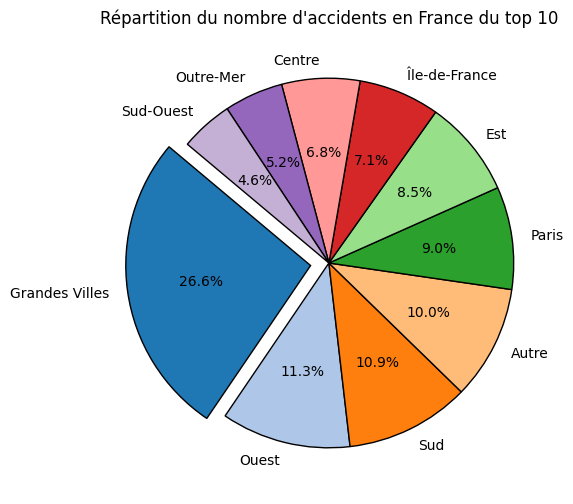

In [ ]:
explode = [0.1 if i == 0 else 0 for i in range(len(acc_per_dep_top_10))]  # Mettre un écart pour le premier élément

plt.figure(figsize=(6, 6))
plt.pie(acc_per_dep_top_10["accidents"],
        labels=acc_per_dep_top_10["dep_cat"],
        autopct='%1.1f%%',  # %
        startangle=140,
        colors=colors[:len(acc_per_dep_top_10)],
        explode=explode,
        wedgeprops={'edgecolor': 'black'})

plt.title('Répartition du nombre d\'accidents en France du top 10')
plt.show()

Les "Grande Villes" sont :

69 : Métropole de Lyon

31 : Métropole de Toulouse

13 : Métropole de Marseille

33 : Métropole de Bordeaux

59 : Métropole de Lille

92, 93, 94 : Banlieue dense de Paris (Hauts-de-Seine, Seine-Saint-Denis, Val-de-Marne)

- Observations : on remarque que les grandes villes possèdes le plus d'accidents, en partie du au regroupement de la population dans ces villes. Ensuite c'est assez bien repartie entre les autres départements.

## Ségmentation des accidents

On va s'intérresser à dépendances entre certaines variables et regarder si il est possible de classifier les accidents en catégorie.

#### Merge de trois des quatres datasets (par simplicité pour le moment)

In [ ]:
df_clustering = caract.merge(lieux, on=["Num_Acc"])
df_clustering = df_clustering.merge(vehicules, on = ["Num_Acc"])

In [ ]:
df_clustering.columns

Index(['Num_Acc', 'mois', 'an', 'heure_categorie', 'lum', 'dep', 'agg', 'int',
       'atm', 'col', 'lat', 'long', 'jour_categorie', 'mois_categorie',
       'dep_cat', 'catr', 'circ', 'nbv', 'prof', 'plan', 'larrout', 'surf',
       'infra', 'situ', 'vma', 'id_vehicule', 'obs', 'obsm', 'choc', 'manv',
       'motor', 'catv_categorie'],
      dtype='object')

Point important : On va garder des caractéristiques évidentes de classification tel que le departement (catégorique) ou le mois. Pour voir si des segmentations intéressantes se font en dehors de celles évidentes

In [ ]:
lat_long = df_clustering[['Num_Acc', 'lat', 'long']].copy()


In [ ]:
num_acc = df_clustering["Num_Acc"]
df_clustering = df_clustering.drop(columns = ["Num_Acc","an","id_vehicule","dep","mois",'lat', 'long'])

#### Pré-traîtement pour segmentation

- One Hot Encoding
- Standardisation (pour kmeans)

In [ ]:
#One Hot Encoding
col_cate = ["heure_categorie","mois_categorie","jour_categorie","lum","agg","int","atm","col","catr","circ","prof","plan","surf","infra","situ","catv_categorie","obs","obsm","choc","manv","motor","dep_cat"]
col_num = [col for col in df_clustering.columns if col not in col_cate]
df_clustering = pd.get_dummies(df_clustering, columns=col_cate,drop_first=True)

In [ ]:
#Standardisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_clustering[col_num] = scaler.fit_transform(df_clustering[col_num])


c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

In [ ]:
df_clustering.head()

nbv   larrout       vma  heure_categorie_matin  heure_categorie_nuit  \
0 -0.065038 -0.535912 -0.920946                   True                 False   
1 -0.775646 -0.535912 -0.920946                   True                 False   
2  0.645571 -0.535912 -0.174253                  False                  True   
3  1.356179 -0.535912 -0.174253                  False                 False   
4  1.356179 -0.535912 -0.174253                  False                 False   

   heure_categorie_soir  mois_categorie_hiver  mois_categorie_printemps  \
0                 False                 False                      True   
1                 False                 False                      True   
2                 False                 False                      True   
3                  True                 False                      True   
4                  True                 False                      True   

   mois_categorie_été  jour_categorie_weekend  ...  dep_cat_Centre  \
0               False                    True  ...           False   
1               False                    True  ...           False   
2               False                    True  ...           False   
3               False                    True  ...           False   
4               False                    True  ...           False   

   dep_cat_Est  dep_cat_Grandes Villes  dep_cat_Nord  dep_cat_Ouest  \
0        False                   False         False          False   
1        False                   False         False          False   
2        False                    True         False          False   
3        False                    True         False          False   
4        False                    True         False          False   

   dep_cat_Outre-Mer  dep_cat_Paris  dep_cat_Sud  dep_cat_Sud-Ouest  \
0              False           True        False              False   
1              False           True        False              False   
2              False          False        False              False   
3              False          False        False              False   
4              False          False        False              False   

   dep_cat_Île-de-France  
0                  False  
1                  False  
2                  False  
3                  False  
4                  False  

[5 rows x 173 columns]

### K-means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Détermination du meilleur k

In [ ]:
# # Recherche du meilleur nombre de clusters avec l’indice de silhouette
# silhouette_scores = []
# inertias = []
# K = range(2, 6)

# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = kmeans.fit_predict(df_clustering)
#     score = silhouette_score(df_clustering, labels)
#     silhouette_scores.append(score)
#     inertias.append(kmeans.inertia_)

# # Visualisation des scores de silhouette
# plt.figure(figsize=(7, 4))
# plt.plot(K, silhouette_scores, marker='o', linestyle='--', label='Silhouette Score', color='green')
# plt.xlabel('Nombre de Clusters (k)')
# plt.ylabel('Score de silhouette')
# plt.title('Indice de silhouette selon k')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Détermination du nombre optimal de clusters
# best_k = K[np.argmax(silhouette_scores)]
# print(f"\n🔹 Meilleur nombre de clusters selon l'indice de silhouette : {best_k}")



#### Selon les scores silhouettes, on en déduit que k = 2. Seulement en testant plusieurs valeurs de k, on obtient des clusters de tailles conséquentes.

### Analyse des clusters selon différents k

In [ ]:
def kmeans_k(df_clustering,k):

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df_clustering['cluster'] = kmeans.fit_predict(df_clustering)

    # Analyse des résultats par cluster
    summary = df_clustering.groupby('cluster').mean()

    # Visualisation de la répartition des clusters
    plt.figure(figsize=(7, 4))
    df_clustering['cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Nombre d’observations')
    plt.title(f'Distribution des clusters (k={k})')
    plt.grid(True)
    plt.show()

    # Écart max-min par variable entre clusters
    diffs = summary.max() - summary.min()
    top_vars = diffs.sort_values(ascending=False).head(15).index

    # Heatmap filtrée
    plt.figure(figsize=(12, 6))
    sns.heatmap(summary[top_vars].T, cmap='coolwarm', center=0)
    plt.title(f'Top variables discriminantes par cluster (k = {k})')
    plt.xlabel('Cluster')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()



    for c in summary.index:
        values = summary.loc[c]

        # Moyenne des autres clusters
        others_mean = summary.drop(index=c).mean()

        # Différence absolue entre ce cluster et la moyenne des autres
        diffs = (values - others_mean).abs()

        # Top variables les plus discriminantes pour CE cluster
        top_vars = diffs.sort_values(ascending=False).head(5).index.tolist()

        # Affichage
        plt.figure(figsize=(6, len(top_vars) * 0.4 + 1))
        sns.heatmap(summary.loc[:, top_vars].T, annot=True, cmap="coolwarm", center=0,
                    cbar=False, linewidths=0.5, linecolor='gray')
        plt.title(f"Variables les plus discriminantes – Cluster {c}")
        plt.xlabel("Cluster")
        plt.ylabel("Variable")
        plt.tight_layout()
        plt.show()

    return df_clustering


#### Clustering pour k = 2

c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


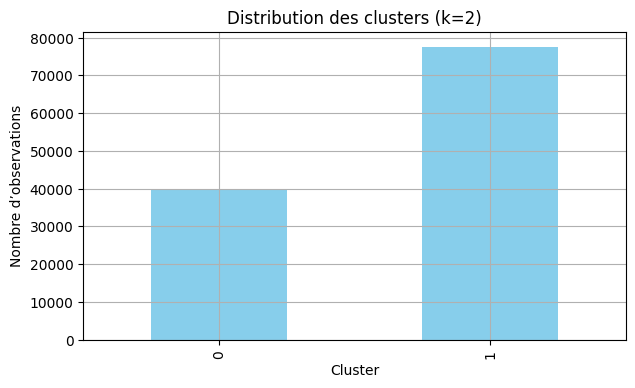

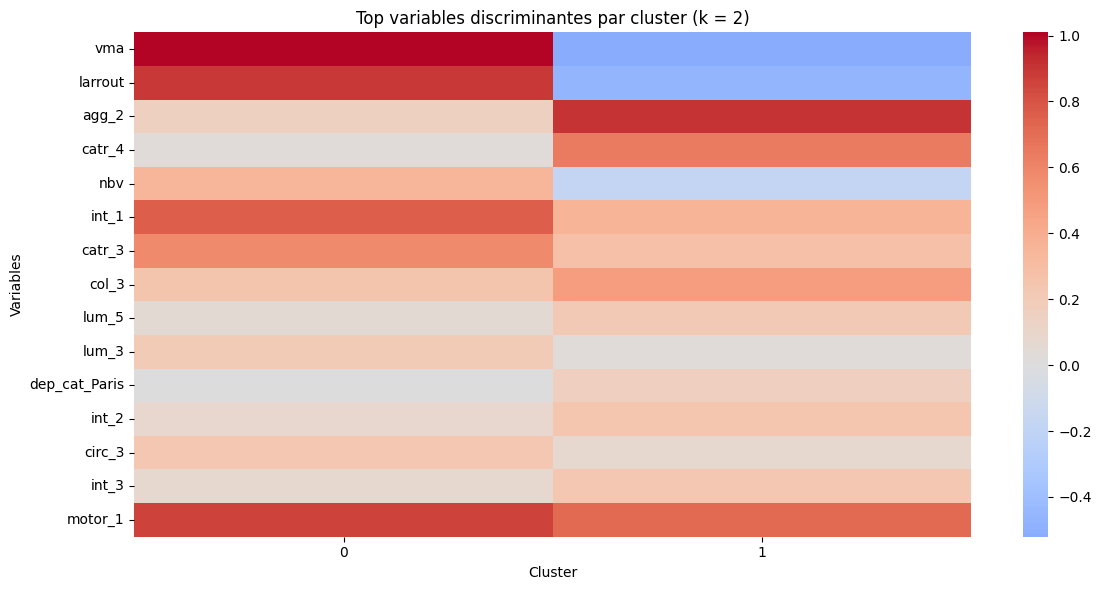

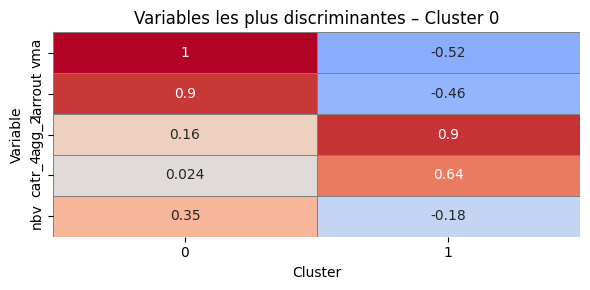

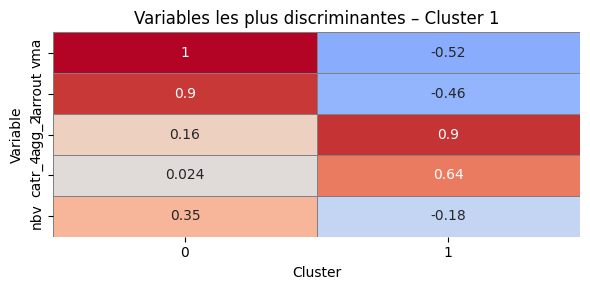

In [ ]:
df_clustering_2 = df_clustering.copy()
df_clustering_2 = kmeans_k(df_clustering_2,2)
df_clustering_2["Num_Acc"] = num_acc

#### Interprétations k = 2 :

La heatmap montre les valeurs moyennes centrées-réduites des variables les plus discriminantes pour chaque cluster.

#### Cluster 0
- Caractéristiques des routes :

    - vma : vitesse maximale autorisée élevée ⟶ routes rapides

    - larrout : largeur de chaussée élevée ⟶ routes larges

    - nbv : nombre de voies élevé ⟶ infrastructures importantes

    - catr_4 : voies communales plus fréquentes

    - int_1 : accidents hors intersection

- Environnement :

    - lum_5 : nuit avec éclairage allumé ⟶ zones urbaines éclairées

    - dep_cat_Paris : très peu représenté ⟶ accidents en province ou périphérie

Conclusion Cluster 0 = accidents sur routes rapides, larges, peu urbaines, souvent hors intersection


#### Cluster 1 (2 fois plus fréquents que le type 0)

- Environnement urbain :

    - agg_2 : en agglomération ⟶ très fréquent

    - catr_3 : routes départementales présentes

    - dep_cat_Paris : très représenté ⟶ accidents en milieu parisien dense

    - int_2, int_3 : intersections X / T fréquentes

    - circ_3 : chaussées séparées ⟶ probable trafic dense et urbain

- Circonstances :

    - col_3 : collisions latérales entre 2 véhicules


Conclusion Cluster 1 = accidents urbains, denses, à Paris ou en agglomération, souvent à des intersections complexes

#### Clustering pour k = 4

c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


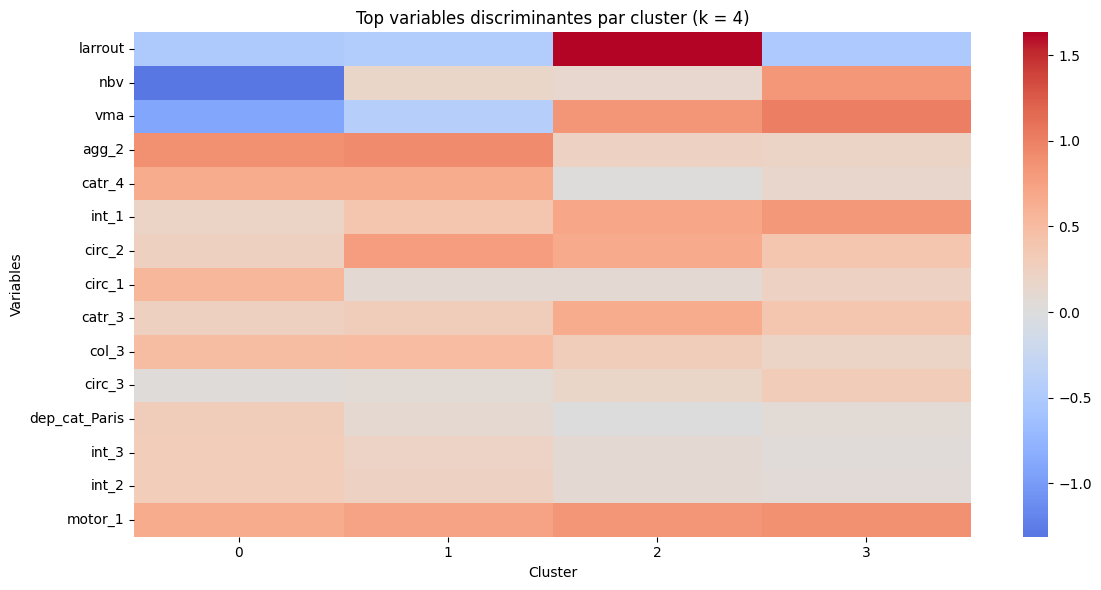

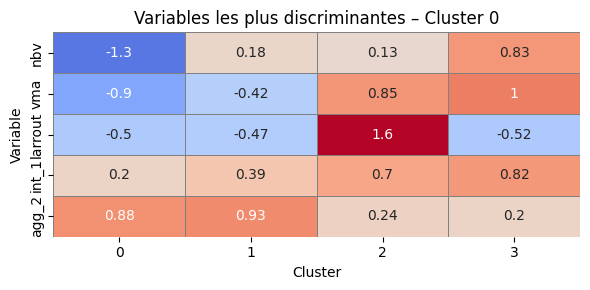

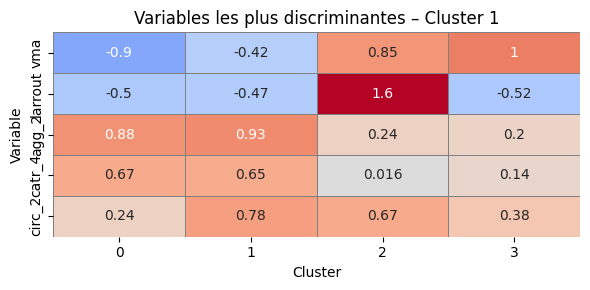

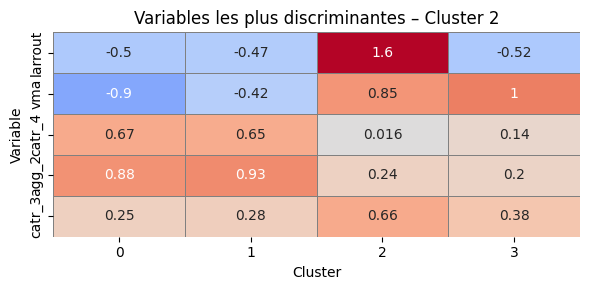

In [ ]:
df_clustering_4 = df_clustering.copy()
df_clustering_4 = kmeans_k(df_clustering_4,4)
df_clustering_4["Num_Acc"] = num_acc

#### Interprétation pour k = 4 :

- Cluster 0 :  routes étroites et lentes, peu de voies

    - nbv, larrout, vma : valeurs les plus faibles

    - agg_2 : en agglomération

    - catr_4 : voie communale typique


    -> Profil : Accidents en zone urbaine dense, sur petites routes, à faible vitesse.
Possiblement quartiers résidentiels, zones 30, périphéries d’agglomération.

- Cluster 1 : mixte urbain à vitesse moyenne

    - Moyennes globalement modérées

    - circ_2 : circulation bidirectionnelle

    - agg_2 élevé → en agglomération

    - Légère surreprésentation de int_1 (hors intersection)

    ->Profil : Accidents en zone urbaine classique, routes standards, intersections moins marquées. Profil neutre, peu spécifique.

- Cluster 2 : routes larges, rapides, peu urbaines

    - larrout, nbv, vma : très élevés

    - agg_2 plus faible → peu d’accidents en agglomération

    - int_1 élevé → hors intersection

    - circ_2 (bidirectionnel) présent

    -> Profil : Accidents sur routes rapides et larges, hors agglomération, peu d’intersections.
Typique des voies rapides interurbaines, nationales ou départementales en rase campagne.

- Cluster 3 : urbain, circulation complexe

    - vma, nbv élevés mais moins qu’en cluster 2

    - agg_2, circ_3 (chaussées séparées), catr_3 (routes départementales) élevés

    - col_3 (collision latérale) + int_2 / int_3 : intersections présentes

    -> Profil : Accidents en milieu urbain, sur axes circulants structurés (boulevards, rocades). Probablement zones périurbaines ou Paris intra-muros.

### Segmentaton à haut k

c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


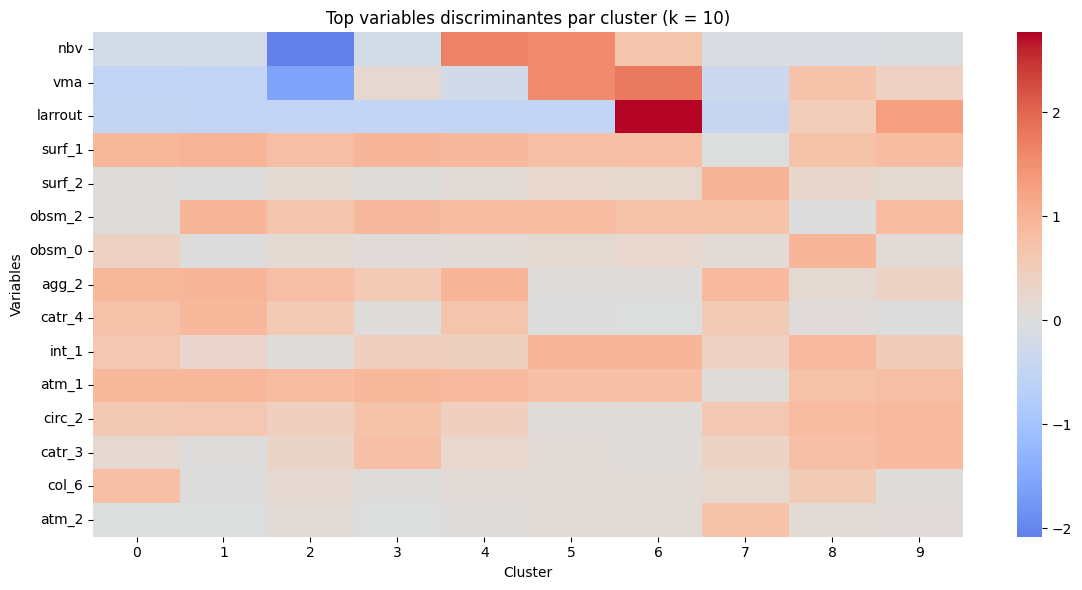

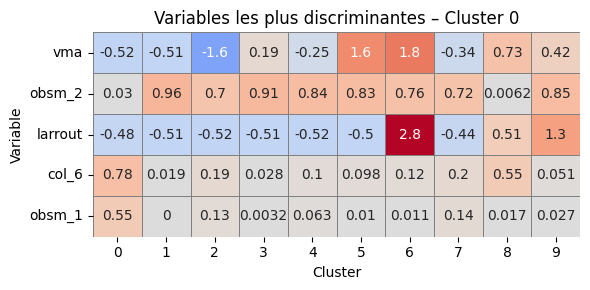

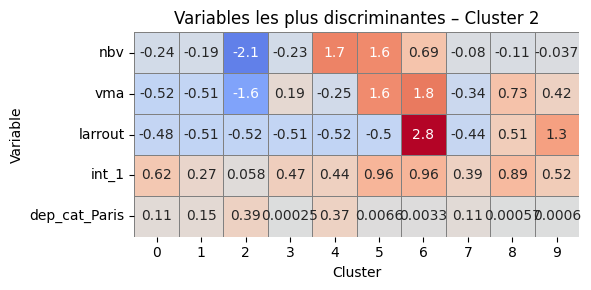

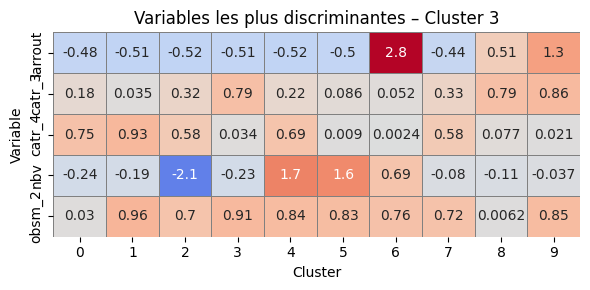

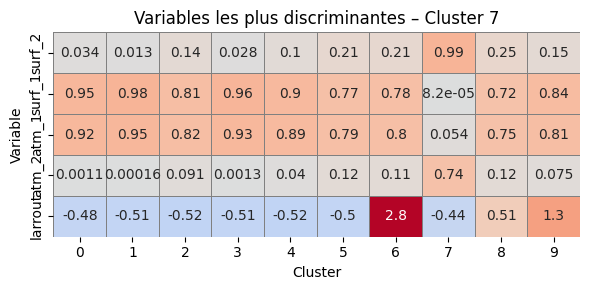

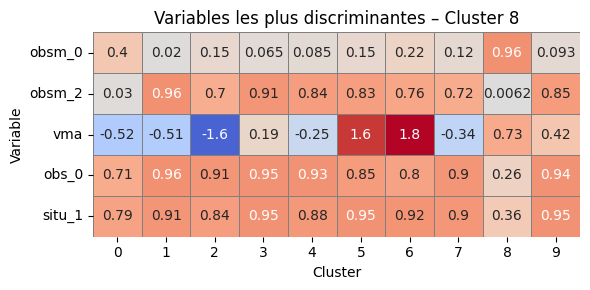

In [ ]:
n = 10
df_clustering_n = df_clustering.copy()
df_clustering_n = kmeans_k(df_clustering_n,n)
df_clustering_n["Num_Acc"] = num_acc

### Interprétation (k=10)

🟠 Cluster 0 :
Moyennes faibles partout

Très légèrement au-dessus pour agg_2, atm_1, col_6

→ Accidents courants en agglomération, sans particularité notable

🟠 Cluster 1 :
Faible nbv, vma, larrout → petites routes

Moyennement urbain (agg_2 ↑)

Glissières et obstacles fixes présents (obsm_2)

→ Accidents sur petites routes urbaines avec obstacles de sécurité (glissière, mobilier)

🟢 Cluster 2 :
nbv très bas, vma et larrout faibles

surf_1/surf_2 ↑ → chaussées mouillées/inondées

Obstacle 0 (arbre) présent

→ Accidents en zone peu structurée, sur chaussée glissante, avec sortie de route ou obstacle

🔴 Cluster 3 :
Très élevé en nbv, vma, larrout

Bas sur tout le reste

→ Accidents sur routes rapides, très larges (probablement autoroutes ou nationales)

🟤 Cluster 4 :
Faible larrout, légèrement ↑ sur obstacles, agg_2, col_6

→ Accidents sur route étroite en agglomération, souvent avec obstacles

🟣 Cluster 5 :
Élevé en agg_2, catr_4, int_1

Routes lentes mais urbaines

→ Accidents sur voies communales en agglomération, hors intersections

🟡 Cluster 6 :
larrout très élevé

Élevé aussi en nbv et vma

→ Accidents sur très grandes routes (rocades, périphériques)

🧡 Cluster 7 :
Accidents plutôt neutres, mais tendance urbain

Légère élévation en catr_4, agg_2, int_1

→ Profil proche de cluster 5 mais moins marqué

🧊 Cluster 8 :
Proche de la moyenne sur presque tout

Léger + sur col_6, atm_2, surf_1

→ Accidents par mauvais temps ou sol glissant, sans motif routier fort

💚 Cluster 9 :
Très léger + sur atm_1, circ_2, catr_3

→ Accidents sur départementales structurées, par beau temps

### Visualisation de la segmentation avec PCA

In [ ]:
from sklearn.decomposition import PCA

#### Explication de la variance

In [ ]:
n = 50
pca = PCA(n_components=n)
X = df_clustering.copy()
print(f"Nombre de colonnes utilisées pour la PCA : {X.shape[1]}")

# Réduction avec PCA
X_pca = pca.fit_transform(X)
# Variance expliquée cumulée
explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, n + 1), explained_var, marker='o')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de variance expliquée')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Explications de la variabilité')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Nombre de colonnes utilisées pour la PCA : 173


c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


- Observation : pour atteindre 90% de variance expliquée, on doit garder environ 50 composantes principales. Cela signifie que la structure des données est très dispersée, il y a beaucoup de variables peu corrélées entre elles ( one-hot encoding large).

In [ ]:
from sklearn.decomposition import PCA
import itertools

def pca_analyse(n_c,df_clustering):
    X = df_clustering.copy()
    pca = PCA(n_components=n_c)
    X = X.drop(columns=['cluster','Num_Acc'])
    print(f"Nombre de colonnes utilisées pour la PCA : {X.shape[1]}")

    # Réduction avec PCA
    X_pca = pca.fit_transform(X)
    df_clustering_pca = df_clustering.copy()
    # Ajout des composantes au DataFrame
    df_clustering_pca['pca1'] = X_pca[:, 0]
    df_clustering_pca['pca2'] = X_pca[:, 1]



    combinations = list(itertools.combinations(range(n_c), 2))
    n_plots = min(len(combinations), 6)  # max 6 sous-graphes pour lisibilité

    plt.figure(figsize=(15, 10))
    for idx, (i, j) in enumerate(combinations[:n_plots]):
        plt.subplot(2, 3, idx+1)
        for cluster in df_clustering['cluster'].unique():
            mask = df_clustering_pca['cluster'] == cluster
            plt.scatter(X_pca[mask, i], X_pca[mask, j], alpha=0.5, label=f'Cluster {cluster}')
        plt.xlabel(f'PCA {i+1}')
        plt.ylabel(f'PCA {j+1}')
        plt.title(f'PCA {i+1} vs PCA {j+1}')
        plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



    #Explication des variables
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PCA_{i+1}' for i in range(pca.n_components_)],
        index=X.columns
    )

    n_top_features = 5

    for i, comp in enumerate(loadings.columns, start=1):
        top_vars = loadings[comp].abs().sort_values(ascending=False).head(n_top_features ).index.tolist()
        print(f"Variables pour {comp} :", top_vars)



    p = 4
    for comp in loadings.columns[:p]:
        top_vars = loadings[comp].abs().sort_values(ascending=False).head(n_top_features).index.tolist()
        plt.figure(figsize=(8, 4))
        plt.bar(top_vars, loadings.loc[top_vars, comp])
        plt.axhline(0, color='gray', linestyle='--')
        plt.xticks(rotation=90)
        plt.title(f'Contribution des top variables à {comp}')
        plt.ylabel('Loading')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


#### PCA à 2 composantes ( exemple pour visualiser, pas très représentatif) : avec le clustering à k = 4

Nombre de colonnes utilisées pour la PCA : 173


c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Variables pour PCA_1 : ['vma', 'larrout', 'nbv', 'agg_2', 'catr_4']
Variables pour PCA_2 : ['nbv', 'larrout', 'catr_3', 'catr_4', 'agg_2']


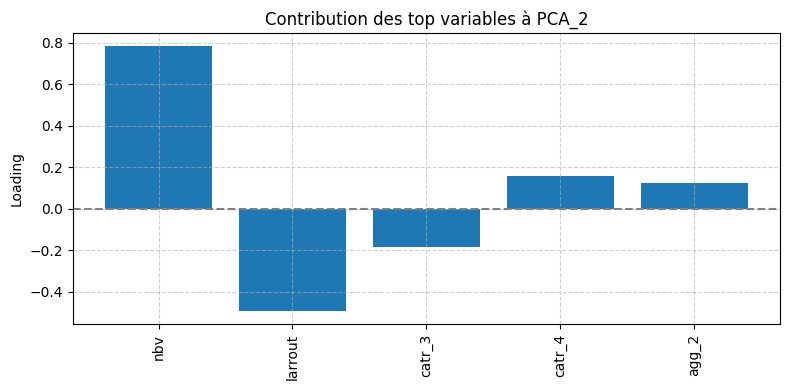

In [ ]:
pca_analyse(2,df_clustering_4)

#### Interprétation (similaire à l'analyse précédente)
🔵 Cluster 0

- Faibles vma, nbv, larrout

- Haut catr_4, agg_2

--> accidents en zone urbaine calme, petites routes communales

🟠 Cluster 1

- Transition modérée : routes un peu plus grandes, mais encore en agglomération

--> Position intermédiaire sur PCA 1 et 2

🟢 Cluster 2

- Très haute vma, larrout, nbv ⟶ routes rapides, larges, probablement hors agglomération

--> Accidents sur grands axes interurbains, voies rapides

🔴 Cluster 3

- nbv élevé, agg_2 modéré, catr_3 intermédiaire

--> Accidents en zone urbaine dense, à fort trafic

### Visualisation géographique de la répartition des clusters

In [ ]:
lat_long

Num_Acc            lat           long
0       202300000001    48,86638600     2,32347100
1       202300000001    48,86638600     2,32347100
2       202300000002    48,84547782     2,42868146
3       202300000003    48,76240000     2,40655000
4       202300000003    48,76240000     2,40655000
...              ...            ...            ...
117669  202300054820   -20,90129000    55,40598000
117670  202300054821     4,89713000   -52,32854000
117671  202300054821     4,89713000   -52,32854000
117672  202300054822    45,73306000     4,82540000
117673  202300054822    45,73306000     4,82540000

[117674 rows x 3 columns]

In [ ]:
import folium

caract_gps = pd.read_csv("acc_routes/caract-2023.csv", sep=";")

df_clustering_geo = df_clustering_n.merge(lat_long, on='Num_Acc', how='left')


In [ ]:
df_clustering_geo["Num_Acc"]

0         202300000001
1         202300000001
2         202300000001
3         202300000001
4         202300000002
              ...     
324315    202300054821
324316    202300054822
324317    202300054822
324318    202300054822
324319    202300054822
Name: Num_Acc, Length: 324320, dtype: int64

In [ ]:
df_clustering_geo['lat'] = df_clustering_geo['lat'].str.replace(',', '.', regex=False).astype(float)
df_clustering_geo['long'] = df_clustering_geo['long'].str.replace(',', '.', regex=False).astype(float)

In [ ]:
df_clustering_geo['long']

0          2.323471
1          2.323471
2          2.323471
3          2.323471
4          2.428681
            ...    
324315   -52.328540
324316     4.825400
324317     4.825400
324318     4.825400
324319     4.825400
Name: long, Length: 324320, dtype: float64

In [ ]:
colors = sns.color_palette("tab10", n).as_hex()

#colors = sns.color_palette("hsv", 4).as_hex()
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [ ]:
df_sample = df_clustering_geo.sample(frac=0.3, random_state=42)

In [ ]:

map_france = folium.Map(location=[46.8, 2.5], zoom_start=6)

for _, row in df_sample.dropna(subset=['lat', 'long']).iterrows():
    # if row['cluster'] == 3 :
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=1,
        color=colors[int(row['cluster'])],
        fill=True,
        fill_color=colors[int(row['cluster'])],
        fill_opacity=0.5
    ).add_to(map_france)

map_france

### Segmentation bis

##### Les variables les plus discriminatives sont : nbv, vma, larrout (on va les delete)

In [ ]:
df_clustering = caract.merge(lieux, on=["Num_Acc"])
df_clustering = df_clustering.merge(vehicules, on = ["Num_Acc"])

In [ ]:
df_clustering = df_clustering.drop(columns = ["Num_Acc","an","id_vehicule","dep","mois","nbv","vma","larrout","lat","long"])

In [ ]:
#One Hot Encoding
col_cate = ["heure_categorie","mois_categorie","jour_categorie","lum","agg","int","atm","col","catr","circ","prof","plan","surf","infra","situ","catv_categorie","obs","obsm","choc","manv","motor","dep_cat"]
col_num = [col for col in df_clustering.columns if col not in col_cate]
df_clustering = pd.get_dummies(df_clustering, columns=col_cate,drop_first=True)

### K = 4

c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


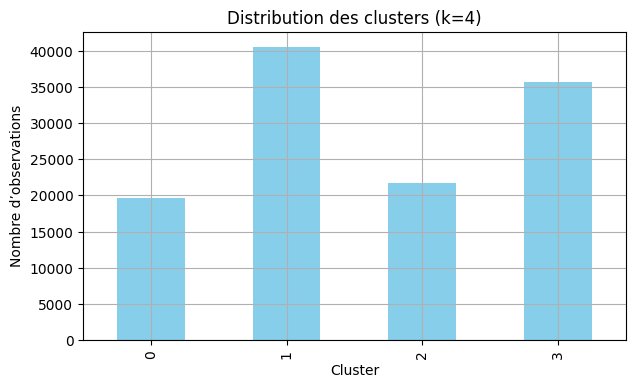

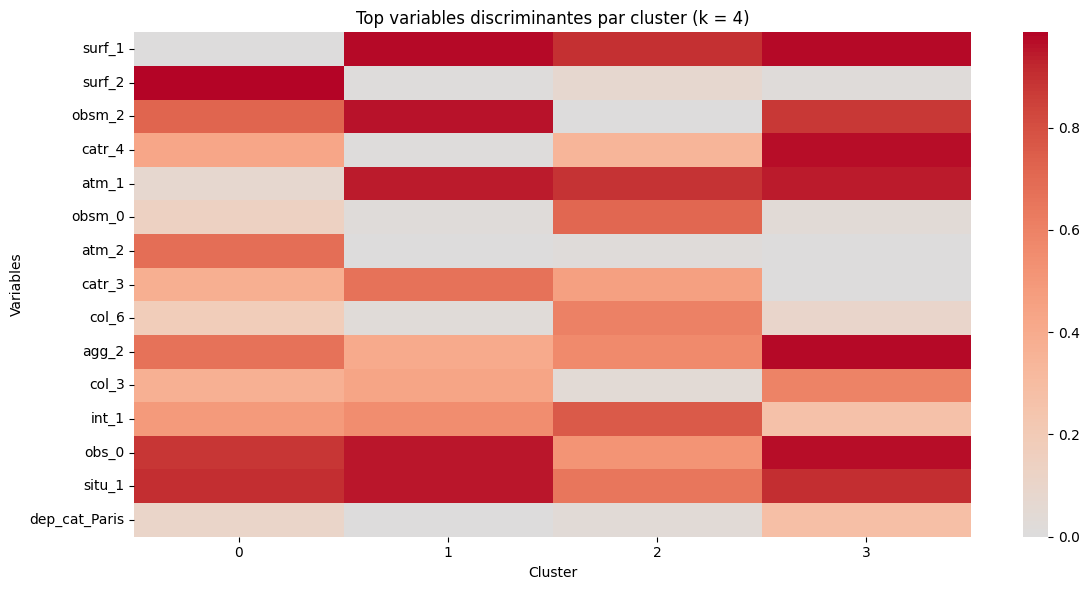

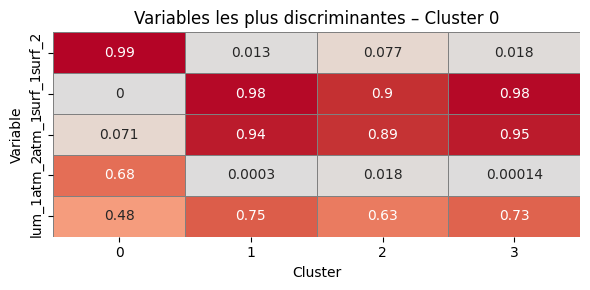

In [ ]:
df_clustering_4_bis = df_clustering.copy()
df_clustering_4_bis = kmeans_k(df_clustering_4_bis,4)

### Intérprétation

🔵 Cluster 0 :
Forte présence de chaussée mouillée (surf_2)

Accidents sur glissière (obsm_2)

Routes en agglomération (agg_2)

Météo dégradée (atm_2)

Voies communales (catr_4)

--> Accidents sur chaussée mouillée en zone urbaine, souvent sur glissières ou mobiliers urbains

🟠 Cluster 1 :
Très élevé sur atm_1 et surf_1 → route sèche et météo normale

Présence de glissières (obsm_2)

Obstacles présents avant choc (obs_0)

Nombreux cas hors intersection (int_1)

--> Accidents sur routes bien dégagées et en bon état, souvent avec obstacle (glissière), hors intersection

🟢 Cluster 2 :
Présence forte de atm_2 → météo mauvaise

Forte présence d’obstacles (obs_0)

Moins marqué sur agglomération → probablement hors agglomération

Collision plus souvent latérale (col_3)

--> Accidents par mauvaise météo, avec obstacle, souvent hors ville, collisions latérales fréquentes

🔴 Cluster 3 :
Très marqué sur voie communale (catr_4), chaussée sèche, en agglomération

Très haut sur Paris (dep_cat_Paris) → probablement urbain dense

Fort sur situ_1 (position normale sur chaussée)

--> Accidents en centre-ville, typiquement à Paris, sur chaussées normales en conditions favorables

### k = 10

c:\Users\benfo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


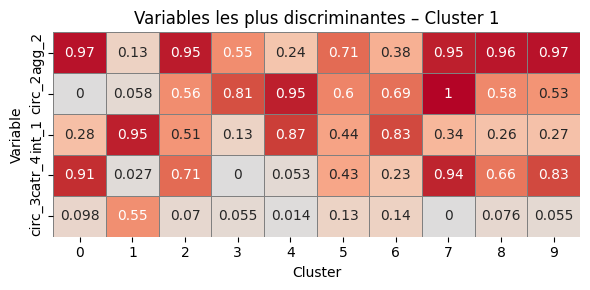

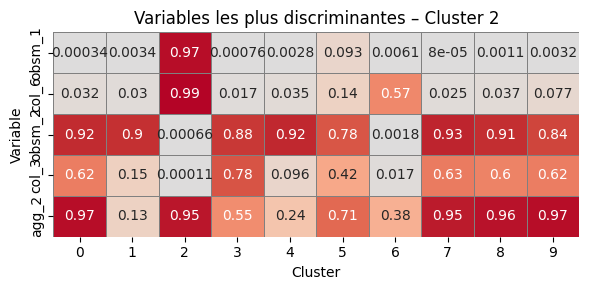

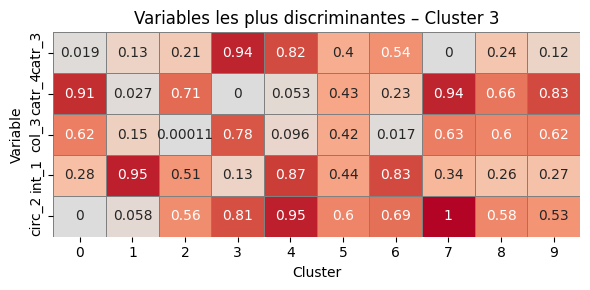

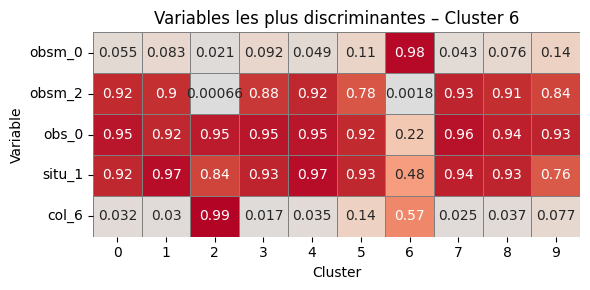

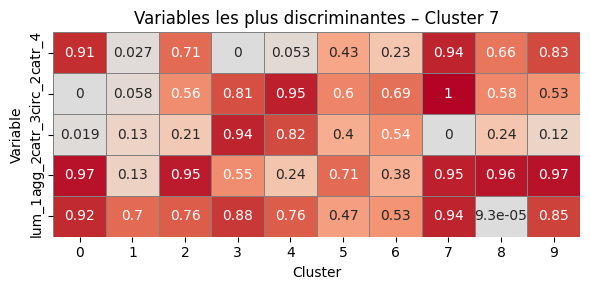

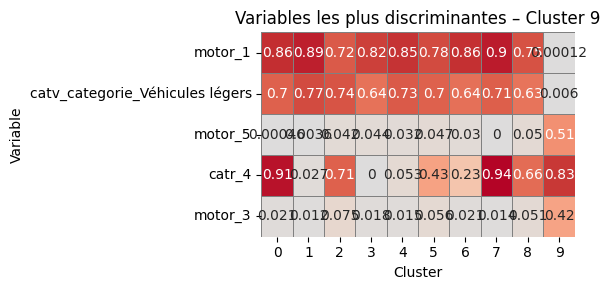

In [ ]:
df_clustering_10_bis = df_clustering.copy()
df_clustering_10_bis = kmeans_k(df_clustering_10_bis,10)

### Interprétation

Cluster 0
Très marqué sur agg_2, atm_1, catr_4, surf_1

Plein jour, route sèche, urbaine

👉 Accidents urbains en plein jour, sur chaussées sèches et voies communales

🟠 Cluster 1
Fort sur col_6, obsm_1 → obstacle mobile (ex : piéton)

Météo normale mais hors intersection

👉 Accidents impliquant piétons ou animaux en ville, sans croisement évident

🟢 Cluster 2
Fort catr_3 (routes départementales), surf_1, atm_1

Accidents dans de bonnes conditions sur routes secondaires

👉 Accidents sur départementales, temps clair, sans causes extérieures apparentes

🔴 Cluster 3
Fort sur circ_2, catr_3, surf_1

👉 Routes bidirectionnelles secondaires (hors agglomération) avec bonnes conditions

🟤 Cluster 4
Fort sur surf_2 (mouillé), agg_2, obsm_2 (glissières)

👉 Accidents en agglomération sur chaussée mouillée, avec glissière

🟣 Cluster 5
Très fort sur surf_1, lum_1, atm_1

👉 Conditions parfaites : plein jour, sec, bon temps – accidents probablement liés à comportement

🟡 Cluster 6
Haut obsm_0, agg_2, obsm_2 : obstacles fixes en ville

Éclairage présent

👉 Accidents en ville contre infrastructure (mobilier urbain, glissières)

🧡 Cluster 7
circ_2, catr_4, atm_2 élevés

👉 Routes urbaines ou interurbaines avec conditions météo dégradées (pluie)

🧊 Cluster 8
Très fort sur lum_5 (nuit éclairée), catr_4, agg_2

👉 Accidents de nuit, éclairés, en agglomération dense

💚 Cluster 9
Très haut en motor_1, agg_2, surf_1

👉 Accidents en agglomération impliquant véhicules motorisés uniquement

## Etude (rapide) plus précise des accidents mortels

### TO-DO

In [70]:
usagers

Num_Acc    id_usager  id_vehicule  place  catu  grav  sexe  \
0       202300000001  203 851 184  155 680 557      1     1     4     1   
1       202300000002  203 851 182  155 680 556      1     1     1     2   
2       202300000002  203 851 183  155 680 556     10     3     3     1   
3       202300000003  203 851 180  155 680 554      1     1     3     1   
4       202300000003  203 851 181  155 680 555      1     1     1     2   
...              ...          ...          ...    ...   ...   ...   ...   
125784  202300054821  203 720 720  155 583 346      1     1     4     1   
125785  202300054821  203 720 721  155 583 347      1     1     1     2   
125786  202300054822  203 720 717  155 583 344      2     2     1     2   
125787  202300054822  203 720 718  155 583 344      1     1     1     2   
125788  202300054822  203 720 719  155 583 345      1     1     3     2   

        an_nais  secu1  locp actp  
0        1978.0      2    -1   -1  
1        1997.0      1    -1   -1  
2        1997.0      0     2    3  
3        1987.0      2     0    0  
4        1984.0      1     0    0  
...         ...    ...   ...  ...  
125784   1971.0      2     0    0  
125785   1968.0      1     0    0  
125786   2003.0      1    -1   -1  
125787   2002.0      1    -1   -1  
125788   1995.0      2    -1   -1  

[125789 rows x 11 columns]

In [141]:
# Tous les imports en haut

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler




In [144]:

place_counts = usagers['place'].value_counts()

place_counts


place
 1     93440
 2     14060
 10     9521
 3      2420
 4      2271
 9      1308
 7      1218
 5       764
 8       583
 6       202
-1         2
Name: count, dtype: int64

In [214]:
# 0. Copie du dataset pour travailler proprement
df_usagers = usagers.copy()
# 1. Création de la variable cible : grav_mortel = 1 si grav == 2 (tué), 0 sinon
df_usagers['grav_mortel'] = (df_usagers['grav'] == 2).astype(int)

# 2. Suppression des colonnes inutiles pour la prédiction
cols_to_drop = ['Num_Acc', 'id_usager', 'id_vehicule', 'grav', 'actp', 'locp', 'an_nais', 'place']
df_usagers = df_usagers.drop(columns=cols_to_drop)

Nous conservons uniquement des caractéristiques pertinentes et peu spécifiques afin d'éviter de surcharger le modèle avec du bruit. Cela nous a amené à garder le sexe, car il peut potentiellement influencer le comportement de conduite ou non, et cela pourrait être intéressant à étudier. Nous avons également conservé le type d’équipement de sécurité, afin d’évaluer son impact réel sur la protection des usagers, ainsi que la catégorie d’usager pour savoir quels types d’usagers ont plus de risque de mortalité. À ce titre, nous avons préféré conserver une distinction simple entre conducteur, passager ou piéton, plutôt que d'ajouter la variable place, dont les classes sont nombreuses, hétérogènes, et auraient introduit trop de bruit.

In [215]:
df_usagers

catu  sexe  secu1  grav_mortel
0          1     1      2            0
1          1     2      1            0
2          3     1      0            0
3          1     1      2            0
4          1     2      1            0
...      ...   ...    ...          ...
125784     1     1      2            0
125785     1     2      1            0
125786     2     2      1            0
125787     1     2      1            0
125788     1     2      2            0

[125789 rows x 4 columns]

On regarde le nombre de données sans renseignement pour ces categories

In [216]:

for col in df_usagers.columns:
    if df_usagers[col].dtype == 'object':
      print(f"Category '{col}' :")
      print(df_usagers[df_usagers[col] == -1][col].count())
    elif df_usagers[col].dtype in ['int64', 'float64']:
      print(f"Numerical Column '{col}' :")
      print(df_usagers[df_usagers[col] == -1][col].count())


Numerical Column 'catu' :
0
Numerical Column 'sexe' :
2431
Numerical Column 'secu1' :
2292
Numerical Column 'grav_mortel' :
0


On en a un peu mais pas un nombre si important on peut juste les supprimer  

In [217]:


for col in df_usagers.columns:
    if df_usagers[col].dtype in ['int64', 'float64']:
        df_usagers[col] = df_usagers[col].replace(-1, pd.NA)
    elif df_usagers[col].dtype == 'object':
      df_usagers[col] = df_usagers[col].replace('-1', pd.NA)

df_usagers = df_usagers.dropna()




In [218]:

for col in df_usagers.columns:
    if df_usagers[col].dtype == 'object':
      print(f"Category '{col}' :")
      print(df_usagers[df_usagers[col] == -1][col].count())
    elif df_usagers[col].dtype in ['int64', 'float64']:
      print(f"Numerical Column '{col}' :")
      print(df_usagers[df_usagers[col] == -1][col].count())


Numerical Column 'catu' :
0
Category 'sexe' :
0
Category 'secu1' :
0
Numerical Column 'grav_mortel' :
0


In [219]:
grav_counts = df_usagers['grav_mortel'].value_counts()
grav_counts


grav_mortel
0    119708
1      3372
Name: count, dtype: int64

Le jeu de données présente un fort déséquilibre entre les accidents mortels et non mortels ; pour corriger ce problème, une technique d'oversampling peut être utilisée afin d'augmenter artificiellement la présence de la classe rare et ainsi permettre au modèle d'apprendre correctement ses caractéristiques. (Sans oversampling notre modele predit que non mortalité car largement majoritere et resultant a une bonne prediction mais donc toujours erroné pour predire la mortalite)

In [222]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer




In [206]:
# Séparer variables explicatives et cible
X = df_usagers.drop(columns=['grav_mortel'])
y = df_usagers['grav_mortel']


In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [208]:

# Appliquer SMOTE sur le train seulement
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Puis on entraîne l'arbre sur X_train_res, y_train_res
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train_res, y_train_res)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [209]:
# Prédictions
y_pred = tree_clf.predict(X_test)

# Rapport de classification
print(classification_report(y_test, y_pred))

# Matrice de confusion
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.65      0.78     35912
           1       0.05      0.63      0.09      1012

    accuracy                           0.65     36924
   macro avg       0.52      0.64      0.44     36924
weighted avg       0.96      0.65      0.76     36924

[[23347 12565]
 [  378   634]]


Le modèle présente une forte capacité à identifier correctement les accidents non mortels (précision de 98 % pour la classe 0), mais il reste relativement faible pour prédire précisément les accidents mortels (précision de seulement 5 % pour la classe 1). Néanmoins, grâce à l'oversampling, le modèle parvient à récupérer une proportion correcte des accidents mortels (recall de 60 %), ce qui montre une amélioration par rapport à un modèle sans rééquilibrage. L'accuracy globale atteint 66 %, mais cette valeur est peu représentative compte tenu du fort déséquilibre initial des classes. L’analyse de la matrice de confusion confirme que, bien que de nombreux accidents non mortels soient mal classés, une partie significative des accidents mortels est correctement détectée, ce qui est prioritaire dans notre contexte d’analyse du risque.

In [210]:
plt.figure(figsize=(20,10))
plot_tree(tree_clf, feature_names=X.columns, class_names=["Non mortel", "Mortel"], filled=True)
plt.title("Arbre de Décision pour la prédiction de la mortalité")
plt.show()


In [211]:
# Récupérer les importances
importances = tree_clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Tracer
plt.figure(figsize=(10,6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.title("Importance des variables dans la prédiction de la mortalité")
plt.show()


### Resultat 1

L'arbre de décision montre que la variable la plus discriminante pour prédire la mortalité est l'équipement de sécurité principal (secu1), suivi par le sexe de l'usager (sexe) et, dans une moindre mesure, par sa catégorie (catu). L'importance très marquée de secu1 souligne le rôle déterminant du port ou non de dispositifs de protection dans la gravité des accidents. Le sexe influence également légèrement la mortalité, ce qui pourrait s'expliquer par des différences physiologiques ou de comportements face au risque. Enfin, la distinction entre conducteur, passager ou piéton (catégorie d'usager) joue un rôle secondaire mais non négligeable. Cela confirme que, dans la majorité des cas, les équipements de sécurité restent un facteur clé pour réduire les risques mortels en cas d'accident.

### Analyse plus detaillé

Il peut être pertinent d'appliquer un one-hot encoding afin de mieux interpréter l'impact individuel de chaque modalité des variables telles que l'équipement de sécurité, le sexe ou la catégorie d'usager.

Ici notre arbre compare des valeurs numériques sans forcément comprendre que chaque valeur correspond à une catégorie différente.

In [212]:
X = df_usagers.drop(columns=['grav_mortel'])
y = df_usagers['grav_mortel']


In [221]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [223]:
# Colonnes à one-hot encoder
categorical_features = ['secu1', 'sexe', 'catu']

# Encodage
encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # garder les autres variables telles quelles
)

# Appliquer l'encodage
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [224]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_encoded, y_train)


In [225]:
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train_res, y_train_res)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [226]:
y_pred = tree_clf.predict(X_test_encoded)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.64      0.78     35912
           1       0.05      0.63      0.09      1012

    accuracy                           0.64     36924
   macro avg       0.52      0.64      0.43     36924
weighted avg       0.96      0.64      0.76     36924

[[23160 12752]
 [  374   638]]


In [231]:
plt.figure(figsize=(20,10))
# Nom des colonnes après encodage
feature_names = encoder.get_feature_names_out()

plot_tree(tree_clf, feature_names=feature_names, class_names=["Non mortel", "Mortel"], filled=True, max_depth=3)
plt.title("Arbre de Décision pour la prédiction de la mortalité")
plt.show()


L’arbre de décision obtenu pour la prédiction de la mortalité fait apparaître plusieurs facteurs déterminants. Le premier critère de séparation est l'utilisation la ceinture de sécurité : les individus portant une ceinture sont majoritairement classés comme "non mortels", tandis que ceux qui n’en portent pas présentent un risque nettement accru. Parmi les usagers sans ceinture, l'absence totale d'équipement aggrave encore la situation, traduisant une vulnérabilité accrue face à la mortalité.

Chez les usagers sans ceinture mais disposant d'un autre équipement, le sexe de l’usager joue également un rôle important : les hommes apparaissent globalement plus exposés au risque de mortalité que les femmes. En approfondissant, la possession d’un dispositif pour enfants semble offrir une certaine protection supplémentaire, en réduisant légèrement la probabilité de décès cela peut être dû à un comportement de conduite plus sûr avec des enfants.

Parmi les porteurs de ceinture, on observe une reconfirmation que le fait d’être un homme accentue le risque de mortalité, mais la majorité reste malgré tout en situation de non-mortalité grâce à l'effet protecteur de la ceinture. Il est quand meme difficile de voir clairement sur cet arbre si la categorie d'usager a un reel impacte.


Ainsi, l’arbre de décision met en évidence l'importance primordiale du port de la ceinture de sécurité pour la survie, suivie de l’influence du sexe masculin comme facteur aggravant.

In [228]:
importances = tree_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title("Importance des variables dans la prédiction de la mortalité")
plt.show()


Le graphique d’importance des variables montre que l’usage de la ceinture de sécurité (cat_secu1_1) est de loin le facteur principal dans la prédiction de la mortalité, avec une importance largement supérieure aux autres variables. L'absence d'équipement de sécurité (cat_secu1_0) arrive en deuxième position, ce qui confirme l'impact majeur de la protection physique sur les chances de survie. Le sexe (cat_sexe_2), ici correspondant au sexe féminin, est également un facteur notable. Nous avions vu plus tôt que les hommes présentent un risque de mortalité plus élevé. Enfin, le type d’usager (cat_catu_3, correspondant aux piétons notamment) a une influence non négligeable, sûrement due au fait qu’un piéton impliqué dans un accident présente un risque de mortalité plus important en raison de sa plus grande vulnérabilité. C’est pour cela que cette catégorie apparaissait dans la partie "mortalité" de l’arbre.